## Уравнение Матье

В колебательных системах, собственная частота колебаний которых варьируется периодическим образом при изменении параметров системы, возникает зачада о [параметрическом резонансе](https://ru.wikipedia.org/wiki/Параметрический_осциллятор). Примерами параметрических осцилляторов является: ребенок на качелях, где периодически изменяющаяся высота центра массы приводит к увеличению амплитуды колебаний качелей, физический маятник, точка подвеса которого совершает заданное периодическое движение в вертикальном направлении, математический маятник, длина нити которого может периодически изменяться.

Одним из возможных типов уравнений, описывающих динамику таких систем, является [уравнение Матье](https://ru.wikipedia.org/wiki/Функции_Матьё): $$ \frac{d^2 x}{dt^2} + (\delta + \varepsilon \cos 2t)x(t) = 0, $$ где $\delta$ и $\varepsilon$ - некоторые константы.

Загрузим библиотечные функции, которые потребуются в дальнейшем. Определим вывод графиков функций в текущий блокнот и определим размер рисунков - 12 на 9 дюймов:

In [144]:
from numpy import cos, arange, linspace, pi, array, empty, meshgrid
from pylab import plot, show, imshow, subplots, rcParams, legend, xlabel, ylabel
from scipy.integrate import odeint
from numpy.linalg import eig
%matplotlib inline
rcParams["figure.figsize"] = (12, 9)

Опишем функцию правой части дифференциального уравнения для вектора неизвестных $x(t)$, нулевым элементом которого будет смещение, а первым - скорость:

In [137]:
def rhs(x, t, delta, eps):
    return array([x[1], -(delta+eps*cos(2*t))*x[0]])

Создадим массив с моментами времени, для которых рассчитаем значения неизвестной $x(t)$. Определим начальные условия для смещения и скорости. 

In [138]:
startTime = 0.
endTime = 20.
NTimeSteps = 200
time = linspace(startTime, endTime, NTimeSteps + 1)
initX = array([1.,0])

Получим численные решения уравнения Матье для различных значений управляющих параметров $\delta$ и $\varepsilon$, результат представим в виде графиков.

In [141]:
delta = 1.
epsilon = 0.5
out0 = odeint(rhs, initX, time, args=(delta, epsilon))

delta = 2.0
epsilon = 0.5
out1 = odeint(rhs, initX, time, args=(delta, epsilon))

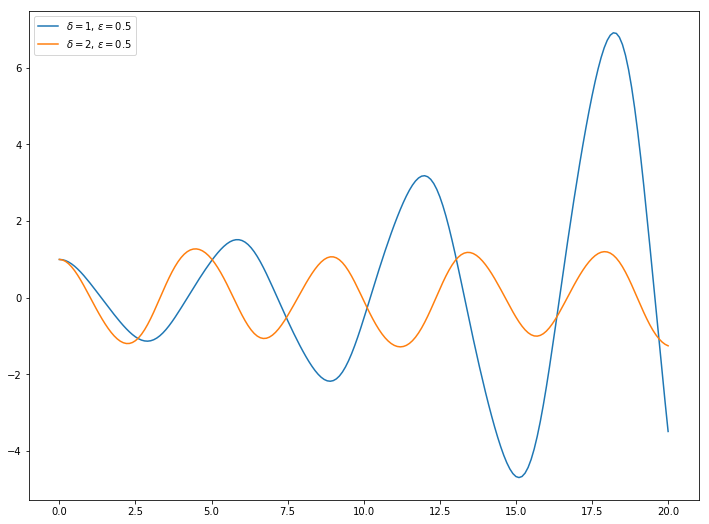

In [142]:
plot(time, out0[:,0], label = r'$\delta = 1$, $\varepsilon = 0.5$');
plot(time, out1[:,0], label = r'$\delta = 2$, $\varepsilon = 0.5$');
legend();

Колебания со времением могут как нарастать, так и  оставаться ограниченными. Затухания в такой системе нет, поскольку нет трения. Вычисление мультипликаторов позволит определить характер колебаний. Опеределим функцию, возвращающую действительную часть максимального мультипликатора.  

In [95]:
startTime = 0.
endTime = pi
NTimeSteps = 1
time = linspace(startTime, endTime, NTimeSteps + 1)

initX0 = array([1.,0])
initX1 = array([0,1.])

def ComputeMaxMult(eps, delta):
    out0 = odeint(rhs, initX0, time, args=(delta, eps))
    out1 = odeint(rhs, initX1, time, args=(delta, eps))
    M = array([[out0[NTimeSteps,0], out0[NTimeSteps,1]], [out1[NTimeSteps,0], out1[NTimeSteps,1]]])
    multipl, v = eig(M)    
    return max(abs(multipl[0].real), abs(multipl[1].real))

В цикле будем перебирать возможные значения параметров $\delta$ и $\varepsilon$, вычислять мультипликаторы.  Результат представим на рисунке.

In [98]:
Ndelta = 51
Nepsilon = 21
epsilonMin = 0.
epsilonMax = 2.
deltaMin = 0.
deltaMax = 5.0
deltas = linspace(deltaMin, deltaMax, Ndelta)
epsilons = linspace(epsilonMin, epsilonMax, Nepsilon)
Deltas, Epsilons = meshgrid(deltas, epsilons)
decremets = empty([Nepsilon, Ndelta])
for i in range(Nepsilon):
    for j in range(Ndelta):
        decremets[i,j] = ComputeMaxMult(epsilons[i], deltas[j])        

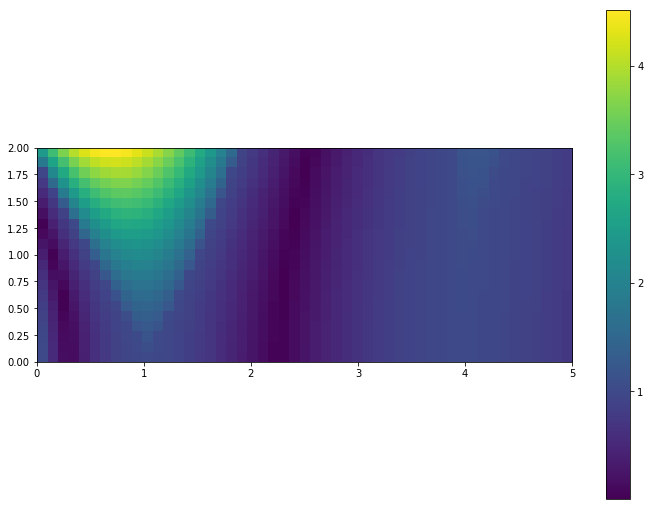

In [99]:
fig, ax = subplots()
im0 = ax.imshow(decremets, extent = (deltaMin, deltaMax, epsilonMin, epsilonMax), origin='lower');
fig.colorbar(im0);

Области параметрического резонсанса, соотвествующие неограниченному нарастанию амплитуды колебаний, определяются условием равенства 1 действительной части максимального мультипликатора. Эти области имеют характерный вид резонансных "мешков", для точного определения этой границы в плоскости параметров $\delta$ - $\varepsilon$ найдем численное решение уравнения $\max (\Re \lambda (\delta,  \varepsilon))= 1$, где $\lambda$ - мультипликатор.

In [106]:
def ComputeMultMinus1(eps, delta):
    return ComputeMaxMult(eps, delta)-1.

Для численного решения нелинейного уравнения воспользуемся [методом хорд](https://ru.wikipedia.org/wiki/Метод_хорд). 

In [107]:
def SolveMult(delta, eps):
    x0 = eps
    x1 = 1.01*eps
    f0 = ComputeMultMinus1(x0, delta)
    f1 = ComputeMultMinus1(x1, delta)
    while (abs(x1-x0)>1e-5):
        x0, x1 = x1, (f1*x0-f0*x1)/(f1-f0)
        f0, f1 = f1, ComputeMultMinus1(x1, delta)
    return x1

 Другой способ - воспользоваться стандарной функцией [scipy.optimize.root_scalar](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html#scipy.optimize.root_scalar).

In [119]:
from scipy.optimize import root_scalar
delta = 0.01
sol = root_scalar(ComputeMultMinus1, args=(delta), bracket=[0, 3], method='brentq')
print(sol)

      converged: True
           flag: 'converged'
 function_calls: 12
     iterations: 11
           root: 1.799290261739893


Перебирая в цикле различные значения $\delta$ посчитаем соотвествующие им значения $\varepsilon$, при которых $\max (\Re \lambda (\delta,  \varepsilon))= 1$, двумя способами: решая уравнение "самописным" методом секущих и стандартным методом.

In [123]:
epsSelfcode = 1.5 #initial guess
deltas = linspace(0.01,1.8,50)
epsilonsNumericalSelfcode = []
epsilonsNumericalScipy = []
for delta in deltas:
    epsSelfcode = SolveMult(delta, epsSelfcode)
    epsilonsNumericalSelfcode.append(epsSelfcode)
    epsScipy = root_scalar(ComputeMultMinus1, args=(delta), bracket=[0, 3], method='brentq')
    epsilonsNumericalScipy.append(epsScipy.root)

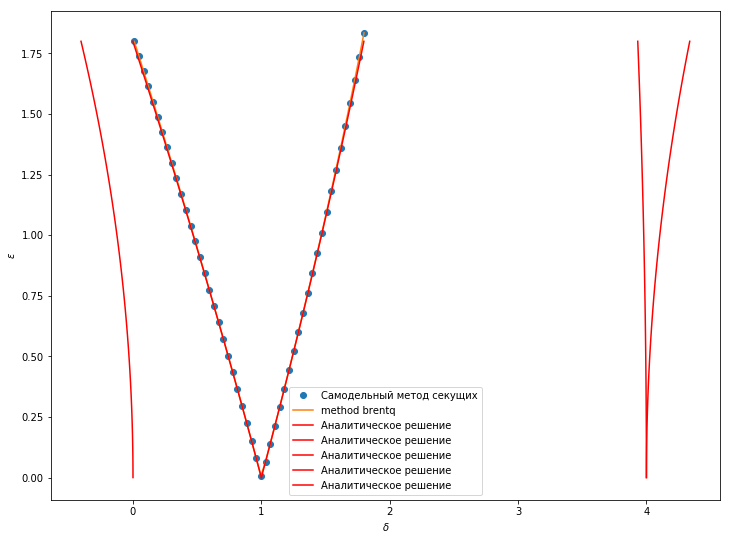

In [145]:
plot(deltas, epsilonsNumericalSelfcode,'o',label = 'Самодельный метод секущих');
plot(deltas, epsilonsNumericalScipy, label = 'method brentq');
epsilons = linspace(0,1.8,50)
deltasAnalytical0 = 1. + 0.5*epsilons-1./32.*epsilons**2
deltasAnalytical1 = 1. - 0.5*epsilons-1./32.*epsilons**2
deltasAnalytical2 = 4. - 1./48.*epsilons**2
deltasAnalytical3 = 4. + 5./48.*epsilons**2
deltasAnalytical4 = -1./8.*epsilons**2
plot(deltasAnalytical0, epsilons, 'r', label = 'Аналитическое решение');
plot(deltasAnalytical1, epsilons, 'r', label = 'Аналитическое решение');
plot(deltasAnalytical2, epsilons, 'r', label = 'Аналитическое решение');
plot(deltasAnalytical3, epsilons, 'r', label = 'Аналитическое решение');
plot(deltasAnalytical4, epsilons, 'r', label = 'Аналитическое решение');
legend();
xlabel(r'$\delta$');
ylabel(r'$\varepsilon$');

Аналитически определить границу параметрического резонанса можно при помощи [метода растянутых координат](https://ftfsite.ru/wp-content/files/fiz_nayfeh_metod_vozm_2.2.pdf).